In [1]:
## required packages for this Chapter
import os, random
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from collections import Counter
from statsmodels.distributions.empirical_distribution import ECDF as ecdf
import seaborn as sns
sns.set_theme()
%matplotlib inline

# To export to PDF, run:
# jupyter nbconvert --to webpdf --allow-chromium-download assignment_01.ipynb

In [4]:
!ls ../Datasets

ABCD             GitHubDevelopers Hypergraph       Reno
Actors           GoT              NCI1             Words
Airports         GridEurope       NCI109           Zachary
Football         GridNorthAmerica Overlap


In [5]:
## setting the path to the datasets
datadir = '../Datasets/'

## Problem 2

In [4]:
## Read GridEurope graph
## read edge list for the grid network and build undirected graph
gr_eu = ig.Graph.Read_Ncol(
    os.path.join(datadir, 'GridEurope/gridkit_europe-highvoltage.edges'), directed=False)
gr_eu = gr_eu.simplify()

## Read GridNorthAmerica graph
## read edge list as tuples and build undirected graph
df = pd.read_csv(
    os.path.join(datadir , 'GridNorthAmerica/gridkit_north_america-highvoltage-links.csv'))[['v_id_1', 'v_id_2']]
tuples = [tuple(x) for x in df.values]
gr_am = ig.Graph.TupleList(tuples, directed=False)

In [5]:
## compute and store basic stats in a table
def baseStats(G):
    deg = G.degree()
    return [G.vcount(),G.ecount(),np.min(deg),np.mean(deg),np.median(deg),np.quantile(deg,.99),
            np.max(deg),G.diameter(),np.max(G.connected_components().membership)+1,G.connected_components().giant().vcount(),
            sum([x==0 for x in G.degree()]),G.transitivity_undirected(mode='nan'),
            G.transitivity_avglocal_undirected(mode='nan')]
S = []
S.append(['GridEurope'] + baseStats(gr_eu))
S.append(['GridNorthAmerica'] + baseStats(gr_am))
D = pd.DataFrame(S,columns=['graph','nodes','edges',r'$d_{min}$',r'$d_{mean}$',r'$d_{median}$',
                            r'$d_{quant_{99}}$',r'$d_{max}$','diameter','components','largest',
                            'isolates',r'$C_{glob}$',r'$C_{loc}$']).round(4).transpose()
D

,0,1
graph,GridEurope,GridNorthAmerica
nodes,13844,16167
edges,17277,22459
$d_{min}$,1,1
$d_{mean}$,2.496,2.7784
$d_{median}$,2.0,3.0
$d_{quant_{99}}$,8.0,9.0
$d_{max}$,16,27
diameter,147,138
components,59,34


**Observation:**
- There are 16,167 nodes and 22,459 edges in `GridNorthAmerica` dataset.
- The characteristics and statistical description (e.g., node degree, diameter, connected components) of the two grid datasets are similar.
- The `GridNorthAmerica` graph has many low-degree nodes. Only 1% nodes have the degree at least than 9.
- The `GridNorthAmerica` also has a diameter (138), so similar to `GridEurope`, its nodes are not as tightly connected.
- This dataset also has one big connected component (14990 nodes) and several small components (38).
- There is no isolated nodes in `GridNorthAmerica` dataset.

## Problem 3

In [4]:
## read the GitHub edge list as tuples and build undirected graph
D = pd.read_csv(datadir+'GitHubDevelopers/musae_git_edges.csv')
tuples = [tuple(x) for x in D.values]
gh = ig.Graph.TupleList(tuples, directed=False)

## read node features
X = pd.read_csv(datadir+'GitHubDevelopers/musae_git_target.csv')

## map node names in edgelist to indices in the graph
idx = [int(i) for i in gh.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['id'].map(sorterIndex) 
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)

cls = ['grey','black'] ## node colors
lbl = ['web','ml']     ## node labels
gh.es['color'] = 'grey' ## edge color

## there are 2 node types: ml or web
gh.vs['color'] = [cls[i] for i in list(X['ml_target'])]
gh.vs['lbl'] = [lbl[i] for i in list(X['ml_target'])]

## build the subgraphs
gh_ml = gh.subgraph([v for v in gh.vs() if v['lbl']=='ml'])
gh_web = gh.subgraph([v for v in gh.vs() if v['lbl']=='web'])

## there are 9739 ml developers and 27961 web developers
print('GitHub nodes:', gh.vcount(), '; ml developers:', gh_ml.vcount(), '; web developers:', gh_web.vcount())

GitHub nodes: 37700 ; ml developers: 9739 ; web developers: 27961


### Problem 3a

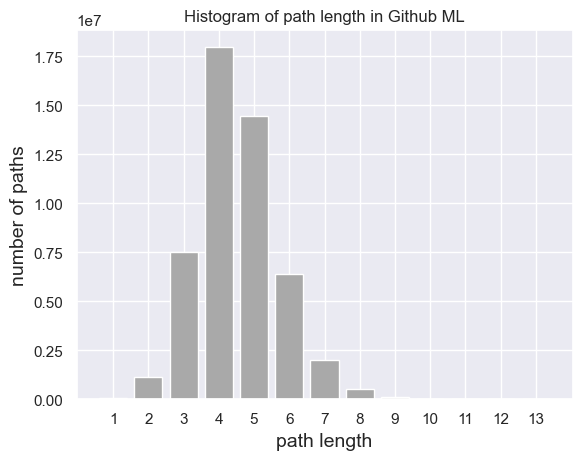

In [5]:
## min path length from that node to other nodes
# sg = gh_ml.connected_components().giant()
V = gh_ml.vs
# V = np.random.choice(sg.vcount(),size=100,replace=False) ## sample
sp = []
for v in V:
    sp.extend(gh_ml.distances(source=v)[0])
    
c = Counter(sp)
c = {i:j for i,j in c.items() if i != np.inf}
s = sorted(c.items())

fig, ax = plt.subplots()
## exclude 0-length paths
x = [x[0] for x in s[1:]]
y = [x[1] for x in s[1:]]
b = ax.bar(x, y, color='darkgrey') 
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.set_xlabel('path length', fontsize=14)
ax.set_ylabel('number of paths', fontsize=14)
ax.set_title('Histogram of path length in Github ML')
plt.show()

In [6]:
print('The number of walks of length 5: {}'.format(c[5]))

The number of walks of length 5: 14474416


### Problem 3b

In [5]:
import itertools

# def is_connected(graph, from_v, to_v):
#     neighbors = [v.index for v in graph.vs[from_v].neighbors()]
#     if to_v in neighbors: return True
#     else: return False

# def is_chordal(graph, vs):
#     return graph.subgraph(vs).is_chordal()

In [6]:
# Get all cycles with length=max_length
# 1-->2-->3-->4-->1
degrees = gh_ml.degree()
vs = gh_ml.vs
max_length = 4
filtered_paths = []
for i in range(len(vs)):
    if i % 1000 == 0: print(i)
    if degrees[i] > 1: # nodes in cycle should have degree > 1
        # get paths with length at most (max_length - 1) (which means n_nodes=max_length)
        paths = gh_ml.get_all_simple_paths(vs[i], to=None, cutoff=max_length-1, mode='all')
        # get paths which can be back to the first node
        for p in paths:
            if len(p) == max_length:
                first_v = p[0]
                last_v = p[-1]
                # check whether last node is connected with first node
                # if is_connected(gh_ml, last_v, first_v):
                if gh_ml.are_connected(first_v, last_v):
                    filtered_paths.append(sorted(p))
                    # we are able to check whether the cycle is chordless or not here,
                    # but the computation of it is expensive, 
                    # so it is better to check in a set of cycles after we drop duplicates

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [7]:
# Drop duplicated cycles before check whether the cycle is chordless or not
print(len(filtered_paths))
cycles = list(filtered_paths for filtered_paths,_ in itertools.groupby(filtered_paths))
print(len(cycles))

1209824
1208559


In [10]:
# Get chordless cycles
chordless_cycles = []
for i,c in enumerate(cycles):
    if i % 100000 == 0: print(i)
    # Since we already check the connectivity of the cycles and
    # the function g.is_chordal() provided by igraph returns an error, 
    # it is better to check the number of edges instead (the computation is also cheaper than is_chordal())
    if len(gh_ml.subgraph(c).es) == max_length: 
        chordless_cycles.append(c)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000


In [11]:
print('The number of chordless cycles of length 4: {}'.format(len(chordless_cycles)))

The number of chordless cycles of length 4: 672787


## Problem 4

In [12]:
## Read airport graph

## Read edges
df_edges = pd.read_csv('../Datasets/Airports/connections.csv')
airport_name = sorted(set(df_edges['orig_airport'].values.tolist() + df_edges['dest_airport'].values.tolist()))
airport2nodeid = {n:i for i,n in enumerate(airport_name)}
df_edges['orig_airport_id'] = df_edges['orig_airport'].map(airport2nodeid)
df_edges['dest_airport_id'] = df_edges['dest_airport'].map(airport2nodeid)
edge_idx = [tuple(x) for x in df_edges[['orig_airport_id', 'dest_airport_id']].values]
weight = list(df_edges['total_passengers'].astype(int).values)

graph = ig.Graph(
    edges=edge_idx,
    edge_attrs={'weight': weight},
    directed=True,
)
graph.vs['name'] = airport_name
df_nodes = pd.read_csv('../Datasets/Airports/airports_loc.csv')
df_nodes['airport_id'] = df_nodes['airport'].map(airport2nodeid)

In [13]:
display(df_edges.head())
display(df_nodes.head())

,orig_airport,dest_airport,total_passengers,orig_airport_id,dest_airport_id
0,SFO,LAX,1442105,400,241
1,LAX,SFO,1438639,241,400
2,MCO,ATL,1436625,272,32
3,ATL,MCO,1424069,32,272
4,LAX,JFK,1277731,241,227


,airport,lon,lat,state,city,airport_id
0,ABE,-75.440804,40.652100,PA,Allentown,0
1,ABI,-99.681900,32.411301,TX,Abilene,1
2,ABQ,-106.609001,35.040199,NM,Albuquerque,2
3,ABR,-98.421799,45.449100,SD,Aberdeen,3
4,ABY,-84.194504,31.535500,GA,Albany,4


### Problem 4a

Slope of the fitted line: -0.8501408835293304


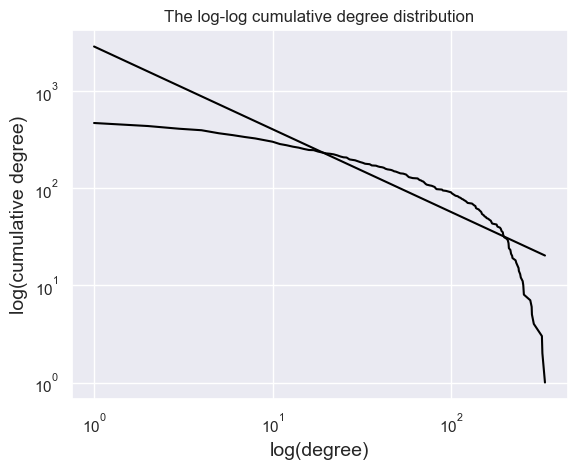

In [14]:
# degree distribution
deg = graph.degree()
c = Counter(deg)
s = sorted(c.items(), reverse=True)
x, cnt = [i[0] for i in s], [i[1] for i in s]
y = np.cumsum(cnt)

min_deg = min(deg)
max_deg = max(deg)

# regression
regressor = LinearRegression()  
log_x = [np.log(i) for i in x]
log_y = [np.log(i) for i in y]
regressor.fit(np.array(log_x).reshape(-1,1), log_y)
print('Slope of the fitted line:', regressor.coef_[0])

# Plot
## plot log-log
plt.loglog(x, y, '-', color='black')
plt.xlabel('log(degree)', fontsize=14)
plt.ylabel('log(cumulative degree)', fontsize=14);

## plot line
b = regressor.intercept_
a = regressor.coef_[0]
plt.plot([min_deg, max_deg],[np.exp(b)*min_deg**a,np.exp(b)*max_deg**a],color='black')
plt.title('The log-log cumulative degree distribution')
plt.show()

### Problem 4b

In [15]:
total_degrees = graph.vs.degree()
maxdeg = max(total_degrees)
airport_names = graph.vs['name']

list_busiest_airport = []
for i,j in zip(airport_names, total_degrees):
    if j == maxdeg:
        list_busiest_airport.append(i)
print(list_busiest_airport)

['ATL']


In [16]:
print('The busiest airport is {} with the total degree {}'.format(list_busiest_airport[0], maxdeg))

The busiest airport is ATL with the total degree 336


### Problem 4c

In [17]:
n_components = len(graph.connected_components(mode='strong'))
print('The number of strongly connected components:', n_components)

The number of strongly connected components: 40


### Problem 4d

In [18]:
ca_airport = df_nodes[df_nodes['state']=='CA']['airport'].unique().tolist()
graph_ca = graph.subgraph([v for v in graph.vs() if v['name'] in ca_airport])
degrees = graph_ca.degree()
num_isolated_nodes = [i for i in degrees if i == 0]
print('The number of isolated nodes:', len(num_isolated_nodes))

The number of isolated nodes: 9


## Problem 5

In [6]:
from geopy.distance import geodesic
from geopy.point import Point
from scipy.stats.stats import pearsonr, spearmanr

In [7]:
## Read GridEurope graph
## read edge list for the grid network and build undirected graph
gr_eu = ig.Graph.Read_Ncol(
    os.path.join(datadir, 'GridEurope/gridkit_europe-highvoltage.edges'), directed=False)
gr_eu = gr_eu.simplify()

## read the vertices along with some of the attributes
X = pd.read_csv(
    os.path.join(datadir, 'GridEurope/gridkit_europe-highvoltage.vertices'))
idx = [int(i) for i in gr_eu.vs['name']]
sorterIndex = dict(zip(idx,range(len(idx))))
X['Rank'] = X['v_id'].map(sorterIndex)
X.sort_values(['Rank'], ascending=[True],inplace=True)
X.dropna(inplace=True)
gr_eu.vs['longitude'] = list(X['lon'])
gr_eu.vs['latitude'] = list(X['lat'])
gr_eu.vs['type'] = list(X['typ'])

In [8]:
def get_geographical_distance(graph, from_v, to_v):
    from_loc = Point(
        latitude=graph.vs[from_v]['latitude'], 
        longitude=graph.vs[from_v]['longitude'])
    to_loc =  Point(
        latitude=graph.vs[to_v]['latitude'], 
        longitude=graph.vs[to_v]['longitude'])
    geographical_distance = geodesic(from_loc, to_loc).kilometers
    return geographical_distance
    
def get_shortest_graph_distance(graph, from_v, to_v):
    results = graph.get_shortest_paths(
        v=from_v,
        to=to_v,
        weights=graph.es['weight'],
    )
    if len(results[0]) > 0:
        # Add up the weights across all edges on the shortest path
        graph_distance = 0
        for e in results[0]:
            graph_distance += graph.es[e]['weight']
        return graph_distance
    else:
        # If the two nodes are not connected
        return np.nan

In [9]:
## We consider the grid network as undirected weighted graph 
## which the the weight is the distance (kilometers) between two nodes.
## Therefore, the graph distance is the shortest path or the minimum total weights between two nodes.
## Add edge weight 
edge_weights = []
for e in gr_eu.es:
    from_v, to_v = e.tuple
    geographical_distance = get_geographical_distance(gr_eu, from_v, to_v)
    edge_weights.append(geographical_distance)
gr_eu.es['weight'] = edge_weights

In [121]:
## Randomly select n_sample node pairs
# random.seed(0)
n_sample = 100
node_indices = sorted(X['Rank'].astype(int).unique())
random.shuffle(node_indices)
# node_pairs = list(zip(*[iter(node_indices)]*2))[:n_sample]
node_pairs = list(zip(random.sample(node_indices, n_sample),random.sample(node_indices, n_sample)))
list_distance = []

## Calculate graph distance and geographical distance (in kilometers) between node pair
for from_v, to_v in node_pairs:
    geographical_distance = get_geographical_distance(gr_eu, from_v, to_v)
    graph_distance = get_shortest_graph_distance(gr_eu, from_v, to_v)
    list_distance.append([from_v, to_v, geographical_distance, graph_distance])

/Users/hoangnguyen/miniconda3/envs/graphmining/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Couldn't reach some vertices at src/paths/dijkstra.c:459
  from ipykernel import kernelapp as app


In [122]:
df_distance = pd.DataFrame(list_distance, columns=['from_v', 'to_v', 'geographical_distance', 'graph_distance'])
df_distance.dropna(inplace=True) # Drop node pairs which are not connected
print(df_distance.shape)

(95, 4)


In [123]:
## Calculate correlation
pearson_corr = pearsonr(df_distance['geographical_distance'], df_distance['graph_distance'])[0]      
spearman_corr = spearmanr(df_distance['geographical_distance'], df_distance['graph_distance'])[0]
print('Pearson correlation: {:.4f}'.format(pearson_corr))
print('Spearman correlation: {:.4f}'.format(spearman_corr))

Pearson correlation: 0.7088
Spearman correlation: 0.6543


**Observation:** The correlation values computed by two methods (i.e., Pearson and Spearman) between the graph distance and geographical distanceare around 0.66 (close 0.7) would indicate that there is a strong and positive relationship exists between the two variables.